In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Update YOUR_USERNAME with your Drive username if needed
base_path = "/content/drive/MyDrive/Fakenews_detection/"
data_path = base_path + "Datasets/"

In [3]:
train_file = "/content/drive/MyDrive/Fakenews_detection/Datasets/train.csv"
test_file = "/content/drive/MyDrive/Fakenews_detection/Datasets/test.csv"
import pandas as pd

train = pd.read_csv(train_file)
test = pd.read_csv(test_file)

train.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
# Overview of columns and data types
train.info()

# Count of missing values
train.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


,0
id,0
keyword,61
location,2533
text,0
target,0


<Axes: title={'center': 'Class Distribution (0 = Fake, 1 = Real)'}, xlabel='target'>

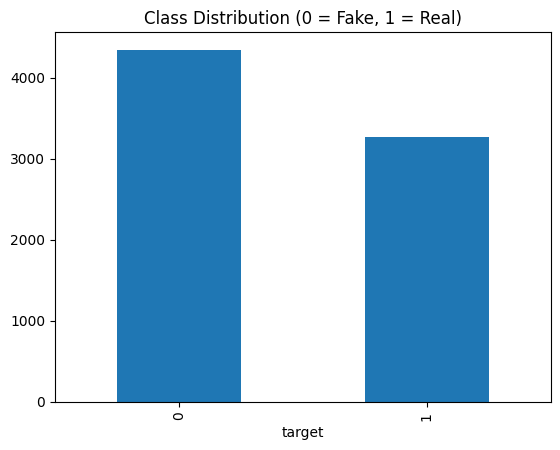

In [5]:
train['target'].value_counts().plot(kind='bar', title='Class Distribution (0 = Fake, 1 = Real)')


In [6]:
# Print a few real tweets
print("Real Tweets:\n", train[train['target'] == 1]['text'].head(), '\n')

# Print a few fake tweets
print("Fake Tweets:\n", train[train['target'] == 0]['text'].head())


Real Tweets:
 0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object 

Fake Tweets:
 15                  What's up man?
16                   I love fruits
17                Summer is lovely
18               My car is so fast
19    What a goooooooaaaaaal!!!!!!
Name: text, dtype: object


In [7]:
train['keyword'].fillna('missing', inplace=True)
train['location'].fillna('missing', inplace=True)



/tmp/ipython-input-7-117764357.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['keyword'].fillna('missing', inplace=True)
/tmp/ipython-input-7-117764357.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

In [8]:
# Show sample real and fake tweets
print("✅ Real tweet example:\n", train[train['target'] == 1]['text'].iloc[0])
print("\n❌ Fake tweet example:\n", train[train['target'] == 0]['text'].iloc[0])


✅ Real tweet example:
 Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all

❌ Fake tweet example:
 What's up man?


In [9]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
def preprocess(text):
    # Remove URLs, mentions, hashtags
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+|\#\w+", '', text)

    # Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z\s]", '', text)

    # Lowercase and tokenize
    text = text.lower().split()

    # Remove stopwords and stem
    text = [stemmer.stem(word) for word in text if word not in stop_words]

    return " ".join(text)


In [11]:
train['clean_text'] = train['text'].apply(preprocess)
test['clean_text'] = test['text'].apply(preprocess)  # same cleaning for test


In [12]:
train[['text', 'clean_text']].head()


,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,deed reason may allah forgiv us
1,Forest fire near La Ronge Sask. Canada,forest fire near la rong sask canada
2,All residents asked to 'shelter in place' are ...,resid ask shelter place notifi offic evacu she...
3,"13,000 people receive #wildfires evacuation or...",peopl receiv evacu order california
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo rubi smoke pour school


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)  # You can change max_features
X = vectorizer.fit_transform(train['clean_text'])
X_test = vectorizer.transform(test['clean_text'])  # For submission later

y = train['target']


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))


              precision    recall  f1-score   support

           0       0.78      0.88      0.83       874
           1       0.81      0.67      0.73       649

    accuracy                           0.79      1523
   macro avg       0.80      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523

[[772 102]
 [215 434]]


In [16]:
test_preds = model.predict(X_test)

submission = pd.read_csv('/content/drive/MyDrive/Fakenews_detection/Datasets/sample_submission.csv')
submission['target'] = test_preds

submission.to_csv('submission.csv', index=False)


In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_val)

from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))


Best parameters: {'C': 1, 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       874
           1       0.81      0.67      0.74       649

    accuracy                           0.79      1523
   macro avg       0.80      0.78      0.78      1523
weighted avg       0.80      0.79      0.79      1523



In [22]:
import numpy as np

# Find indices where prediction != true label
misclassified_indices = np.where(y_val != y_pred)[0]


In [23]:
# Reset index of original train data to align with X_val
y_val_reset = y_val.reset_index(drop=True)

# Use misclassified indices to get original rows from train
misclassified_texts = train.iloc[y_val_reset.index[misclassified_indices]]

# Show first few misclassified tweets
print(misclassified_texts[['text', 'target']].head())


                                                 text  target
0   Our Deeds are the Reason of this #earthquake M...       1
6   #flood #disaster Heavy rain causes flash flood...       1
7   I'm on top of the hill and I can see a fire in...       1
16                                      I love fruits       0
30                                           The end!       0


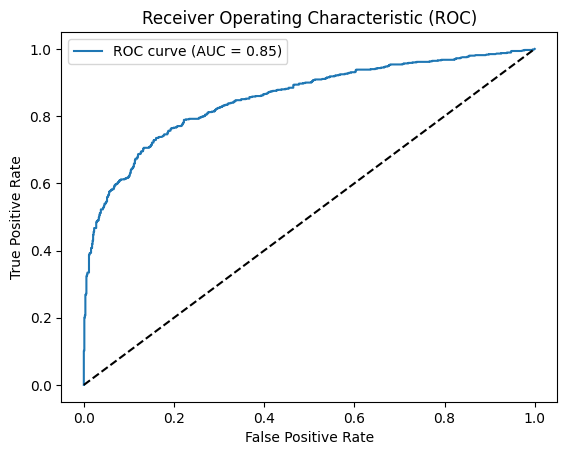

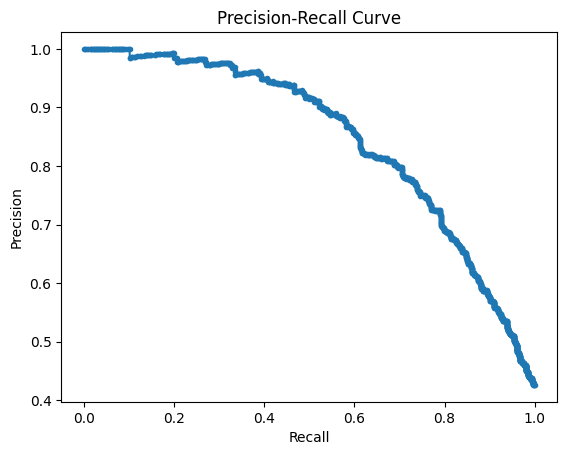

In [19]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

y_proba = best_model.predict_proba(X_val)[:,1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, y_proba)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
